![Banner](./img/AI_Special_Program_Banner.jpg)

# Exercise on Feature Engineering
---

In this exercise, you will apply feature engineering methods to improve the performance of a ML model. Feature engineering is more of an art than an exact science and requires some creative work. This exercise is therefore designed to be very open and exploratory. Your task will be to develop and empirically evaluate **your own feature engineering methods**.

## Data preparation and a baseline model
---

In this section, we read in the data and develop an initial baseline model. We use a customized subset (145,572 rows) of the [NYC Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview) dataset from a Kaggle competition. The goal of this data is to predict the trip duration (`trip_duration`) of a cab ride in New York City as accurately as possible. It is therefore a **regression problem**. The competition was announced with prize money of \\$30,000.

### Reading in the data

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('./data/nyc_taxi.csv')

In [3]:
df.head()

,index,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,571578,id2141905,2,2016-03-31 16:04:41,1,-73.971916,40.757042,-73.974663,40.753624,0,113
1,1280332,id0996953,2,2016-04-21 21:54:52,2,-73.961891,40.771061,-73.906311,40.908562,0,2037
2,177838,id1572284,1,2016-03-30 11:26:24,3,-74.010338,40.711674,-73.957047,40.777634,0,1811
3,1433776,id0103694,1,2016-03-06 20:07:45,1,-74.005898,40.740093,-73.992287,40.758511,0,977
4,757662,id2548956,1,2016-04-06 13:45:10,1,-74.011063,40.715599,-74.005035,40.720966,0,342


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145572 entries, 0 to 145571
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   index               145572 non-null  int64  
 1   id                  145572 non-null  object 
 2   vendor_id           145572 non-null  int64  
 3   pickup_datetime     145572 non-null  object 
 4   passenger_count     145572 non-null  int64  
 5   pickup_longitude    145572 non-null  float64
 6   pickup_latitude     145572 non-null  float64
 7   dropoff_longitude   145572 non-null  float64
 8   dropoff_latitude    145572 non-null  float64
 9   store_and_fwd_flag  145572 non-null  int64  
 10  trip_duration       145572 non-null  int64  
dtypes: float64(4), int64(5), object(2)
memory usage: 12.2+ MB


For this exercise, we only work with **10% of the original data** to reduce the calculation time of the models and feature engineering procedures.

**Features of the data** (see [here](https://www.kaggle.com/c/nyc-taxi-trip-duration/data)):

* **id** - a unique identifier for each trip
* **vendor_id** - a code indicating the provider associated with the trip record
* **pickup_datetime** - date and time when the meter was engaged
* **passenger_count** - the number of passengers in the vehicle (driver entered value)
* **pickup_longitude** - the longitude where the meter was engaged
* **pickup_latitude** - the latitude where the meter was engaged
* **dropoff_longitude** - the longitude where the meter was disengaged
* **dropoff_latitude** - the latitude where the meter was disengaged
* **store_and_fwd_flag** - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server - 1=store and forward; 0=not a store and forward trip

**Target:**

* **trip_duration** - duration of the trip in seconds

### Baseline model

A random forest model was selected as the baseline. As we are working with a significantly smaller amount of data compared to the original data, the default RF model unfortunately suffers from overfitting. The parameters `max_features` and `max_depth` were each adjusted to reduce overfitting.

In [5]:
MAX_FEATURES = 0.5
MAX_DEPTH = 8

In [6]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag']

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate

X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
baseline = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
baseline_scores = cross_validate(
    baseline, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)

print(f"RMSE: Train-Score: {-1*baseline_scores['train_score'].mean():.2f} - Test Score: {-1*baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 433.47 - Test Score: 440.95


<h1 style="color:blue">Exercise</h1>

---

In this exercise you have only one goal: **improve the performance of the baseline model through feature engineering!**  
You can use the pipeline of the baseline model above and add your new features to the `cols_to_train` list. Evaluate your new features analogous to the baseline model using the [RMSE](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.mean_squared_error.html) score. It is best to determine the performance of new features individually in comparison to the baseline before finally using them in combination.

The best RMSE test score achieved in the sample solution is *332.83*. Can you beat this?

**Possible starting points:**

* **Log transformation** of the `trip_duration` target
    * Check whether the distribution of the target is suitable for a log transformation
    * To test the effect of a log transformation, you can use the [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn-compose-transformedtargetregressor). This allows you to reverse the prediction with the `inverse_func` parameter in order to make the RMSE values comparable.
* Extraction of **date information** from `pickup_datetime`. *Surely the travel time of a cab ride depends on the time of day...*
* Calculation of **distances** from the geocoordinates `pickup_longitude`, `pickup_latitude`, `dropoff_longitude`, `dropoff_latitude`.
    * Note that the distances are to be calculated on the basis of an ellipse ($\hat =$ Earth). You can calculate these [geodesics](https://de.wikipedia.org/wiki/Geod%C3%A4te) with [Geopy](https://geopy.readthedocs.io/en/stable/#module-geopy.distance), for example.
    * Since cabs don't fly (*yet*), you could also use more meaningful distances. *New York City = [Manhattan distance](https://en.wikipedia.org/wiki/Taxicab_geometry)?*
* Consideration of **holidays**. *Different travel times could perhaps be expected here...*
    * This can be implemented with the Pandas [Holiday-Calendar](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#holidays-holiday-calendars), for example
* **Clustering of the geodata**. You could use [MiniBatchKMeans](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.MiniBatchKMeans.html) to cluster the locations based on the geocoordinates. The start and end cluster could be a good predictor of travel time.
* Use of **external weather data**. *Perhaps shorter distances are increasingly traveled by cab in bad weather*
    * You can use the file `./data/weather_data_nyc_centralpark_2016.csv` for this (based on [here](https://www.kaggle.com/mathijs/weather-data-in-new-york-city-2016))
    * The T in the data stands for Trace (was recognized, but not enough for a measurement)

The points mentioned are only an initial selection of possible feature engineering approaches. You are welcome to experiment and develop your own ideas! Finally, to achieve the best performance, you can use your predictive features in combination.

## Log transformation of the target

<Axes: ylabel='Frequency'>

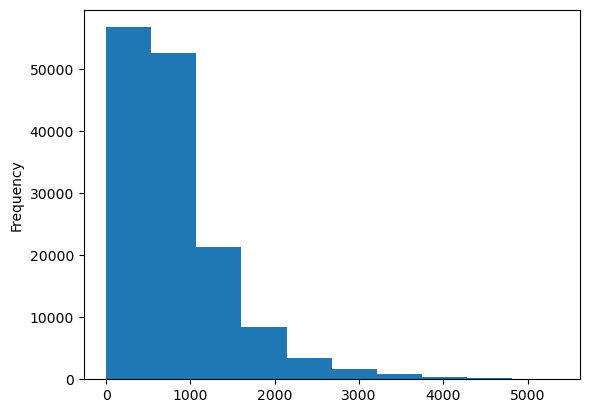

In [8]:
df['trip_duration'].plot(kind='hist')

The distribution is clearly skewed to the right and could be improved with a log transformation.

In [9]:
df['log_trip_duration'] = np.log1p(df['trip_duration'])

<Axes: ylabel='Frequency'>

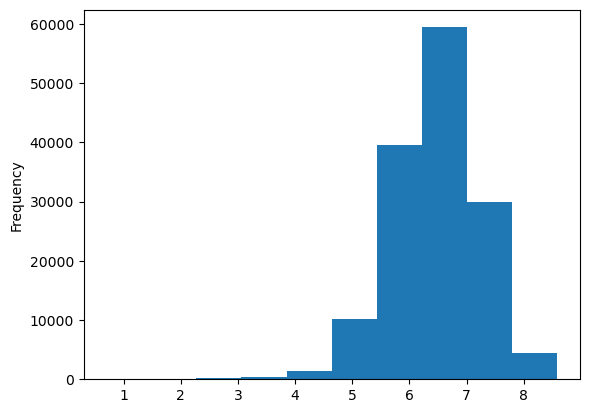

In [10]:
df['log_trip_duration'].plot(kind='hist')

The resulting distribution looks better. Finally, we can test this with the [TransformedTargetRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.compose.TransformedTargetRegressor.html#sklearn-compose-transformedtargetregressor), as we can specify the inverse function for the prediction there. This makes the RMSE measures comparable:

In [11]:
from sklearn.compose import TransformedTargetRegressor

X = df[cols_to_train].copy()
y = df['trip_duration']

regr_trans = TransformedTargetRegressor(regressor = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH),
                                       func = np.log1p,
                                       inverse_func=np.expm1)

regr_trans_scores = cross_validate(
    regr_trans, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)

print(f"RMSE: Train-Score: {-1*regr_trans_scores['train_score'].mean():.2f} - Test Score: {-1*regr_trans_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 443.68 - Test Score: 448.69


The RMSE has even increased! This is at least consistent with the study by [Florian Wilhelm](https://florianwilhelm.info/2020/05/honey_i_shrunk_the_target_variable/). We therefore use the original distribution of the `trip_duration` below.

### Date

In [12]:
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

In [13]:
df['pickup_weekday'] = df['pickup_datetime'].dt.weekday
df['pickup_weekofyear'] = df['pickup_datetime'].dt.isocalendar().week
df['pickup_hour'] = df['pickup_datetime'].dt.hour
df['pickup_minute'] = df['pickup_datetime'].dt.minute

In [14]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 
                 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute']

In [15]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
date_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
date_scores = cross_validate(
    date_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)

print(f"RMSE: Train-Score: {-1*date_scores['train_score'].mean():.2f} - Test Score: {-1*date_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 421.34 - Test Score: 427.66


Adding the date provides a significant improvement. Let's take a look at the Feature Importance for verification:

In [16]:
baseline.fit(X,y)

RandomForestRegressor(max_depth=8, max_features=0.5, n_jobs=-1, random_state=0)

In [17]:
list(zip(cols_to_train,baseline.feature_importances_))

[('vendor_id', 0.00014386278393303922),
 ('passenger_count', 0.0003074688642794477),
 ('pickup_longitude', 0.3216061740980296),
 ('pickup_latitude', 0.1741237963739429),
 ('dropoff_longitude', 0.24680046788185836),
 ('dropoff_latitude', 0.18501128635306038),
 ('store_and_fwd_flag', 5.4044193934629125e-05),
 ('pickup_weekday', 0.009444463817564072),
 ('pickup_weekofyear', 0.0033881700114485793),
 ('pickup_hour', 0.057912231890998984),
 ('pickup_minute', 0.0012080337309500512)]

The geocoordinates are the most important, followed by the `pickup_hour`. This seems to make sense.

### Distances

Calculation of a simple distance (as the crow flies) between two points. Earth is an ellipse, so the [geodesic](https://de.wikipedia.org/wiki/Geod%C3%A4te) must be determined using [Geopy](https://geopy.readthedocs.io/en/stable/#).

In [18]:
from geopy import distance

In [19]:
df['distance'] = df.apply(lambda x: distance.distance((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['dropoff_longitude'])).km, axis=1)

In [20]:
df.loc[:5,'distance']

0     0.444817
1    15.972880
2     8.597141
3     2.346118
4     0.783958
5     3.457005
Name: distance, dtype: float64

In [21]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 'distance']

In [22]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
dist_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
dist_scores = cross_validate(
    dist_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*dist_scores['train_score'].mean():.2f} - Test Score: {-1*dist_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*dist_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 359.80 - Test Score: 368.35
Baseline Test Delta: -72.60


By adding the distance, a huge improvement was achieved.

### Manhattan distance

In [23]:
df['manhattan_distance'] = (df.apply(lambda x: distance.distance((x['pickup_latitude'],x['pickup_longitude']),(x['pickup_latitude'],x['dropoff_longitude'])).km +
                                         distance.distance((x['pickup_latitude'],x['pickup_longitude']),(x['dropoff_latitude'],x['pickup_longitude'])).km, axis=1))

In [24]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 'manhattan_distance']

In [25]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
mandist_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
mandist_scores = cross_validate(
    mandist_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*mandist_scores['train_score'].mean():.2f} - Test Score: {-1*mandist_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*mandist_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 363.57 - Test Score: 372.32
Baseline Test Delta: -68.63


The improvement due to the Manhattan distance is comparatively less than due to the distance as the crow flies.

### Holidays

In [26]:
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar

In [27]:
cal = calendar()
holidays = cal.holidays(start=df['pickup_datetime'].min(), end=df['pickup_datetime'].max(), return_name=False)

In [28]:
df['holiday'] = df['pickup_datetime'].dt.date.isin(holidays.date)

In [29]:
df['holiday'].value_counts()

holiday
False    143605
True       1967
Name: count, dtype: int64

In [30]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 'holiday']

In [31]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
holiday_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
holiday_scores = cross_validate(
    holiday_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*holiday_scores['train_score'].mean():.2f} - Test Score: {-1*holiday_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*holiday_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 432.13 - Test Score: 439.91
Baseline Test Delta: -1.04


Only a small improvement could be achieved by adding the public holidays. However, the number of public holidays in the data set is also very low, so the effect on the error is also small.

### External data: Weather

In [32]:
weather = pd.read_csv('./data/weather_data_nyc_centralpark_2016.csv', parse_dates=['date'], dayfirst=True)

In [33]:
weather.head()

,date,maximum temperature,minimum temperature,average temperature,precipitation,snow fall,snow depth
0,2016-01-01,42,34,38.0,0.00,0.0,0
1,2016-01-02,40,32,36.0,0.00,0.0,0
2,2016-01-03,45,35,40.0,0.00,0.0,0
3,2016-01-04,36,14,25.0,0.00,0.0,0
4,2016-01-05,29,11,20.0,0.00,0.0,0


In [34]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   date                 366 non-null    datetime64[ns]
 1   maximum temperature  366 non-null    int64         
 2   minimum temperature  366 non-null    int64         
 3   average temperature  366 non-null    float64       
 4   precipitation        366 non-null    object        
 5   snow fall            366 non-null    object        
 6   snow depth           366 non-null    object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(3)
memory usage: 20.1+ KB


For the sake of simplicity, we replace the T values with zero:

In [35]:
weather.replace('T', 0.0, inplace=True)

In [36]:
weather[['precipitation', 'snow fall', 'snow depth']] = weather[['precipitation', 'snow fall', 'snow depth']].astype('float')

In [37]:
df['date'] = pd.to_datetime(df['pickup_datetime'].dt.date)

Merge the data:

In [38]:
df = pd.merge(df, weather, on='date').drop('date', axis=1)

In [39]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 'maximum temperature', 
                 'minimum temperature', 'average temperature', 'precipitation', 'snow fall', 'snow depth']

In [40]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
weather_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
weather_scores = cross_validate(
    weather_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*weather_scores['train_score'].mean():.2f} - Test Score: {-1*weather_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*weather_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 435.28 - Test Score: 444.93
Baseline Test Delta: 3.98


Unfortunately, the weather data did not bring about any improvement.

### Geo Clustering

In [41]:
coords = np.vstack((df[['pickup_latitude', 'pickup_longitude']].values,
                    df[['dropoff_latitude', 'dropoff_longitude']].values))

In [42]:
from sklearn.cluster import MiniBatchKMeans
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=500,random_state=42, n_init=3).fit(coords)

In [43]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_latitude', 'pickup_longitude']].values)
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_latitude', 'dropoff_longitude']].values)

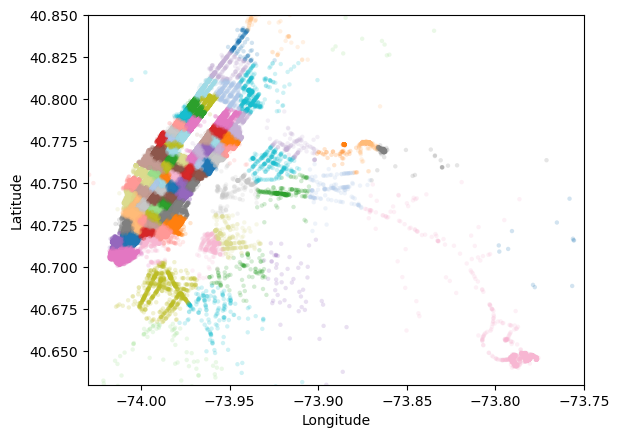

In [44]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)

fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(df.pickup_longitude.values[:100000], df.pickup_latitude.values[:100000], s=10, lw=0,
           c=df.pickup_cluster[:100000].values, cmap='tab20', alpha=0.2)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

The outline of Manhattan can be seen particularly clearly here. The two denser clusters outside are the two airports John F. Kennedy and LaGuardia.

In [45]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 
                 'pickup_cluster', 'dropoff_cluster']

In [46]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
geoclust_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
geoclust_scores = cross_validate(
    geoclust_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*geoclust_scores['train_score'].mean():.2f} - Test Score: {-1*geoclust_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*geoclust_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 434.66 - Test Score: 442.37
Baseline Test Delta: 1.42


Unfortunately, the geo-clusters were also unable to bring about any improvement.

## Combination of features

Finally, we combine the features for a final evaluation.

### Only features with negative delta

In [47]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 
                 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 
                 'distance','manhattan_distance','holiday']

In [48]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
all_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
all_scores = cross_validate(
    all_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*all_scores['train_score'].mean():.2f} - Test Score: {-1*all_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*all_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 325.24 - Test Score: 332.70
Baseline Test Delta: -108.25


Feature engineering therefore enables us to achieve considerable performance gains compared to the raw data.

### All Features

Out of interest, let's take a look at the model based on all the features:

In [49]:
cols_to_train = ['vendor_id', 'passenger_count', 'pickup_longitude','pickup_latitude',
                 'dropoff_longitude','dropoff_latitude','store_and_fwd_flag', 
                 'pickup_weekday', 'pickup_weekofyear', 'pickup_hour', 'pickup_minute', 
                 'distance','manhattan_distance','holiday',
                 'maximum temperature', 'minimum temperature', 'average temperature', 'precipitation', 
                 'snow fall', 'snow depth',
                 'pickup_cluster', 'dropoff_cluster']

In [50]:
X = df[cols_to_train].copy()
y = df['trip_duration']

# Train and score baseline model
all_rf = RandomForestRegressor(random_state=0, n_jobs=-1, max_features=MAX_FEATURES, max_depth=MAX_DEPTH)
all_scores = cross_validate(
    all_rf, X, y, cv=5, scoring="neg_root_mean_squared_error", return_train_score=True
)
print(f"RMSE: Train-Score: {-1*all_scores['train_score'].mean():.2f} - Test Score: {-1*all_scores['test_score'].mean():.2f}")
print(f"Baseline Test Delta: {-1*all_scores['test_score'].mean() + baseline_scores['test_score'].mean():.2f}")

RMSE: Train-Score: 324.45 - Test Score: 332.88
Baseline Test Delta: -108.07


This could be interesting for more complex models, as the performance is hardly worse. However, only if more data is used to avoid overfitting.

> More good feature engineering ideas can be found in [this notebook](https://www.kaggle.com/gaborfodor/from-eda-to-the-top-lb-0-367) for the Kaggle competition.